In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import csv
import numpy as np
import time
import os


In [ ]:
print(cv2.__version__)
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16


3.4.2


In [ ]:
print(cv2.__version__)

3.4.2


In [ ]:
def input_transform2():
    return transforms.Compose([
        transforms.Resize((256,256)),  #전체데이터 한번에 가져올때 resize안해주면 메모리터짐  128,128
        transforms.ToTensor()        
    ])
bef_train_imagenet_data = datasets.ImageFolder('/gdrive/My Drive/b1dataset/b1train', transform=input_transform2())
bef_test_imagenet_data = datasets.ImageFolder('/gdrive/My Drive/b1dataset/b1test', transform=input_transform2())
print(len(bef_train_imagenet_data))
print(len(bef_test_imagenet_data))

14878
1961


In [ ]:
from __future__ import absolute_import

def compute(check_index,qimage,dbimage,eps=1e-7):
  extractor = cv2.xfeatures2d.SIFT_create()
  kps1,descs1 = extractor.detectAndCompute(qimage,None)
  kps2,descs2 = extractor.detectAndCompute(dbimage,None)
  #print("변화전",descs1)
  #print("kps1, des1 :",kps1,descs1)
  #print("kps2, des2 :",kps2,descs2)

  # apply the Hellinger kernel by first L1-normalizing and taking the
  # square-
  if descs1 is None:
    print("query의 {} 번째 이미지가 None".format(check_index))
    return (0,0,0)
  else:
    descs1 /= (descs1.sum(axis=1, keepdims=True) + eps)
    descs1 = np.sqrt(descs1)

  if descs2 is None:
    print("query의 {}에서 database None나옴".format(check_index))
    descs2 = np.ones(descs1.shape)
  else:
    descs2 /= (descs2.sum(axis=1, keepdims=True) + eps)
    descs2 = np.sqrt(descs2)

  bf = cv2.BFMatcher()
  good = []
  try:
    matches = bf.knnMatch(descs1,descs2, k=2)
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append([m])
    
  except:
    good.append([])
    print("database 추가없음")
      
  return (kps1 , kps2,good)

[[0.  0.2 0.4]
 [0.6 0.8 1. ]]
[[0. 0. 0.]
 [0. 0. 0.]]


In [ ]:
# 이미지 이름만 긁어오기
test_image_name=[]
train_image_name=[]
for i in range(len(bef_train_imagenet_data)):
  train_image_name.append(bef_train_imagenet_data.imgs[i][0].split('DDD/')[1])

print(len(train_image_name), train_image_name[26786])

for i in range(len(bef_test_imagenet_data)):
  test_image_name.append(bef_test_imagenet_data.imgs[i][0].split('DDD/')[1])
print(len(test_image_name), test_image_name[1960])

#print(train_image_name[])



IndexError: ignored

RootSift로 10개중 젤 비슷한거 찾기

In [ ]:
pred=pd.read_csv('/gdrive/My Drive/dataset/b2prediction.csv',header=None)
save_csvpath='/gdrive/My Drive/dataset/remove.csv'
# concat=np.empty((len(bef_test_imagenet_data),2))
# print("concat shape: ",concat.shape)
# concat=concat.tolist()

start=time.time()

for q_index in range( 1505,1507): # len(bef_test_imagenet_data) 0 ~
  breaker=False
  list_index=pred[q_index:q_index+1].values[0]
  #print("선택된 list index", list_index)

  qimage=cv2.imread(bef_test_imagenet_data.imgs[q_index][0])
  qimage = cv2.cvtColor(qimage, cv2.COLOR_BGR2RGB)
  good_list=[]

  for i in range(10):
    
    dbimage=cv2.imread(bef_train_imagenet_data.imgs[list_index[i]][0])
    dbimage = cv2.cvtColor(dbimage, cv2.COLOR_BGR2RGB)

    kps1,kps2,good =compute(q_index,qimage,dbimage)

    if (kps1 and kps2 and good) == 0:
      query_filename = test_image_name[q_index]
      db_filename = train_image_name[list_index[0]]
      soda = {'Query': [query_filename], 'DB': [db_filename]}
      df.to_csv(save_csvpath, index=False, mode='a', header=False)
      breaker==True
      break
      
    good_list.append(len(good))

  if breaker==True:
    break
  # print(list_index)
  # print(good_list ,max(good_list),good_list.index(max(good_list)))
  db_index=list_index[good_list.index(max(good_list))]
  
  query_filename = test_image_name[q_index]
  db_filename = train_image_name[db_index]
  # print("선택된 qu image 이름: ",query_filename)
  # print("선택된 db image 이름과 : ",db_filename, db_index)
  soda = {'Query': [query_filename], 'DB': [db_filename]}
  df = pd.DataFrame(soda)
  if not os.path.exists(save_csvpath):
      df.to_csv(save_csvpath, index=False, mode='w')
  else:
      df.to_csv(save_csvpath, index=False, mode='a', header=False)


  if q_index%10 == 0:
    end=time.time()-start
    print("{} 까지 걸린 시간 {}".format(q_index,end))




end=time.time()-start
print("최종걸린시간 :",end)



최종걸린시간 : 322.2303445339203


0 까지 걸린시간 40   / 32
100까지 걸린 시간 6541  / 4630
300까지  / 12436

query 1169에서 non db 나옴

엑셀 1623 번의 329.jpg의 db데이터베이스 확인하기



In [ ]:
for i in range(1500,1960):  #len(bef_test_imagenet_data)
  print(i, "   ",test_image_name[i])


In [ ]:
#무결성 검사기
pred=pd.read_csv('/gdrive/My Drive/dataset/b2concat_to1961.csv',header=None)
for i in range(1380,len(bef_test_imagenet_data)): # len(bef_test_imagenet_data)
  list_index=pred[i+1:i+2].values[0][0]
  #print(str(test_image_name[i])== list_index )
  if (str(test_image_name[i])== list_index ) == False:
    print(i, " 에서 ",str(test_image_name[i]),"  ",list_index )
  

In [ ]:
nrows=100
figure, axes = plt.subplots(nrows = nrows, ncols = 2)
figure.set_size_inches(28,  300)
pred=pd.read_csv('/gdrive/My Drive/dataset/b2concat_to1961.csv',header=None)
imgnum=5
cnt=1
for i in range(100):
  b1Q=pred[i+1:i+2].values[0][0]
  b1Q = os.path.join('/gdrive/My Drive/b1dataset/b1test/b1testDDD', b1Q)
  
  b1D=pred[i+1:i+2].values[0][1]
  if os.path.exists(os.path.join('/gdrive/My Drive/b1dataset/b1train/2019-04-16_15-35-46DDD',b1D) ):
    b1D = os.path.join('/gdrive/My Drive/b1dataset/b1train/2019-04-16_15-35-46DDD',b1D)
  
  elif os.path.exists(os.path.join('/gdrive/My Drive/b1dataset/b1train/2019-04-16_16-14-48DDD',b1D) ):
    b1D = os.path.join('/gdrive/My Drive/b1dataset/b1train/2019-04-16_16-14-48DDD',b1D) 
  
  else:
    b1D = os.path.join('/gdrive/My Drive/b1dataset/b1train/2019-08-20_10-41-18DDD',b1D)
  print("선택된 이미지들 ",b1Q ," ",b1D)
  qimage=cv2.imread(b1Q)
  qimage = cv2.cvtColor(qimage, cv2.COLOR_BGR2RGB)

  dbimage=cv2.imread(b1D)
  try:
    dbimage = cv2.cvtColor(dbimage, cv2.COLOR_BGR2RGB)
    plt.subplot(nrows,2,cnt)
    plt.imshow(qimage)
    cnt+=1
    plt.subplot(nrows,2,cnt)
    plt.imshow(dbimage)
    cnt+=1
  except:
    print("{}번째 오류".format(i))
  

#나쁜 이미지 5

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 오류검사까지 하는 코드
figure, axes = plt.subplots(nrows = 10, ncols = 1)
figure.set_size_inches(28, 128)

pred=pd.read_csv('/gdrive/My Drive/dataset/b2prediction.csv',header=None)
check_index=880
list_index=pred[check_index:check_index+1].values[0]


for i in range(10):
  print(i, list_index[i])
  qimage=cv2.imread(bef_test_imagenet_data.imgs[check_index][0])
  qimage = cv2.cvtColor(qimage, cv2.COLOR_BGR2RGB)

  dbimage=cv2.imread(bef_train_imagenet_data.imgs[list_index[i]][0])
  dbimage = cv2.cvtColor(dbimage, cv2.COLOR_BGR2RGB)

  kps1,kps2,good =compute(check_index,qimage,dbimage)

  if (kps1 and kps2 and good) == 0:
    print("시프트 검출 불가")
    plt.subplot(1,1,i+1)
    dbimage=cv2.imread(bef_train_imagenet_data.imgs[list_index[0]][0])
    dbimage = cv2.cvtColor(dbimage, cv2.COLOR_BGR2RGB)
    plt.imshow(dbimage)
    break
  #print(good)
  else:
    img3 = cv2.drawMatchesKnn(qimage,kps1, dbimage,kps2,good,None ,flags=2,matchColor=[0,0,255])
    plt.subplot(10,1,i+1)
    plt.imshow(img3)
# 4 7 9

최종걸린시간 : 30.170189142227173


In [ ]:
# 오류검사까지 하는 코드
figure, axes = plt.subplots(nrows = 10, ncols = 1)
figure.set_size_inches(28, 128)

pred=pd.read_csv('/gdrive/My Drive/dataset/b2prediction.csv',header=None)
check_index=0
list_index=pred[check_index:check_index+1].values[0]


for i in range(10):
  
  qimage=cv2.imread(bef_test_imagenet_data.imgs[check_index][0])
  qimage = cv2.cvtColor(qimage, cv2.COLOR_BGR2RGB)

  dbimage=cv2.imread(bef_train_imagenet_data.imgs[list_index[i]][0])
  dbimage = cv2.cvtColor(dbimage, cv2.COLOR_BGR2RGB)

  kps1,kps2,good =compute(check_index,qimage,dbimage)
  print(i, list_index[i], len(good))
  if (kps1 and kps2 and good) == 0:
    print("시프트 검출 불가")
    plt.subplot(1,1,i+1)
    dbimage=cv2.imread(bef_train_imagenet_data.imgs[list_index[0]][0])
    dbimage = cv2.cvtColor(dbimage, cv2.COLOR_BGR2RGB)
    plt.imshow(dbimage)
    break
  #print(good)
  else:
    img3 = cv2.drawMatchesKnn(qimage,kps1, dbimage,kps2,good,None ,flags=2,matchColor=[0,0,255])
    plt.subplot(10,1,i+1)
    plt.imshow(img3)
# 4 7 9

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 오류검사까지 하는 코드
figure, axes = plt.subplots(nrows = 10, ncols = 1)
figure.set_size_inches(28, 128)

pred=pd.read_csv('/gdrive/My Drive/dataset/b2prediction.csv',header=None)
check_index=1
list_index=pred[check_index:check_index+1].values[0]


for i in range(10):
  qimage=cv2.imread(bef_test_imagenet_data.imgs[check_index][0])
  qimage = cv2.cvtColor(qimage, cv2.COLOR_BGR2RGB)

  dbimage=cv2.imread(bef_train_imagenet_data.imgs[list_index[i]][0])
  dbimage = cv2.cvtColor(dbimage, cv2.COLOR_BGR2RGB)

  kps1,kps2,good =compute(check_index,qimage,dbimage)
  print(i, list_index[i], len(good))
  if (kps1 and kps2 and good) == 0:
    print("시프트 검출 불가")
    plt.subplot(1,1,i+1)
    dbimage=cv2.imread(bef_train_imagenet_data.imgs[list_index[0]][0])
    dbimage = cv2.cvtColor(dbimage, cv2.COLOR_BGR2RGB)
    plt.imshow(dbimage)
    break
  #print(good)
  else:
    img3 = cv2.drawMatchesKnn(qimage,kps1, dbimage,kps2,good,None ,flags=2,matchColor=[0,0,255])
    plt.subplot(10,1,i+1)
    plt.imshow(img3)
# 4 7 9

In [ ]:
# 오류검사까지 하는 코드
figure, axes = plt.subplots(nrows = 10, ncols = 1)
figure.set_size_inches(28, 128)

pred=pd.read_csv('/gdrive/My Drive/dataset/b2prediction.csv',header=None)
check_index=2
list_index=pred[check_index:check_index+1].values[0]


for i in range(10):
  
  qimage=cv2.imread(bef_test_imagenet_data.imgs[check_index][0])
  qimage = cv2.cvtColor(qimage, cv2.COLOR_BGR2RGB)

  dbimage=cv2.imread(bef_train_imagenet_data.imgs[list_index[i]][0])
  dbimage = cv2.cvtColor(dbimage, cv2.COLOR_BGR2RGB)

  kps1,kps2,good =compute(check_index,qimage,dbimage)
  print(i, list_index[i], len(good))
  if (kps1 and kps2 and good) == 0:
    print("시프트 검출 불가")
    plt.subplot(1,1,i+1)
    dbimage=cv2.imread(bef_train_imagenet_data.imgs[list_index[0]][0])
    dbimage = cv2.cvtColor(dbimage, cv2.COLOR_BGR2RGB)
    plt.imshow(dbimage)
    break
  #print(good)
  else:
    img3 = cv2.drawMatchesKnn(qimage,kps1, dbimage,kps2,good,None ,flags=2,matchColor=[0,0,255])
    plt.subplot(10,1,i+1)
    plt.imshow(img3)
# 4 7 9

In [ ]:
# 오류검사까지 하는 코드
figure, axes = plt.subplots(nrows = 10, ncols = 1)
figure.set_size_inches(28, 128)

pred=pd.read_csv('/gdrive/My Drive/dataset/b2prediction.csv',header=None)
check_index=3
list_index=pred[check_index:check_index+1].values[0]


for i in range(10):
  
  qimage=cv2.imread(bef_test_imagenet_data.imgs[check_index][0])
  qimage = cv2.cvtColor(qimage, cv2.COLOR_BGR2RGB)

  dbimage=cv2.imread(bef_train_imagenet_data.imgs[list_index[i]][0])
  dbimage = cv2.cvtColor(dbimage, cv2.COLOR_BGR2RGB)

  kps1,kps2,good =compute(check_index,qimage,dbimage)
  print(i, list_index[i], len(good))
  if (kps1 and kps2 and good) == 0:
    print("시프트 검출 불가")
    plt.subplot(1,1,i+1)
    dbimage=cv2.imread(bef_train_imagenet_data.imgs[list_index[0]][0])
    dbimage = cv2.cvtColor(dbimage, cv2.COLOR_BGR2RGB)
    plt.imshow(dbimage)
    break
  #print(good)
  else:
    img3 = cv2.drawMatchesKnn(qimage,kps1, dbimage,kps2,good,None ,flags=2,matchColor=[0,0,255])
    plt.subplot(10,1,i+1)
    plt.imshow(img3)
# 4 7 9

In [ ]:
# 오류검사까지 하는 코드
figure, axes = plt.subplots(nrows = 10, ncols = 1)
figure.set_size_inches(28, 128)

pred=pd.read_csv('/gdrive/My Drive/dataset/b2prediction.csv',header=None)
check_index=4
list_index=pred[check_index:check_index+1].values[0]


for i in range(10):
  
  qimage=cv2.imread(bef_test_imagenet_data.imgs[check_index][0])
  qimage = cv2.cvtColor(qimage, cv2.COLOR_BGR2RGB)

  dbimage=cv2.imread(bef_train_imagenet_data.imgs[list_index[i]][0])
  dbimage = cv2.cvtColor(dbimage, cv2.COLOR_BGR2RGB)

  kps1,kps2,good =compute(check_index,qimage,dbimage)
  print(i, list_index[i], len(good))
  if (kps1 and kps2 and good) == 0:
    print("시프트 검출 불가")
    plt.subplot(1,1,i+1)
    dbimage=cv2.imread(bef_train_imagenet_data.imgs[list_index[0]][0])
    dbimage = cv2.cvtColor(dbimage, cv2.COLOR_BGR2RGB)
    plt.imshow(dbimage)
    break
  #print(good)
  else:
    img3 = cv2.drawMatchesKnn(qimage,kps1, dbimage,kps2,good,None ,flags=2,matchColor=[0,0,255])
    plt.subplot(10,1,i+1)
    plt.imshow(img3)
# 4 7 9

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 오류검사까지 하는 코드
figure, axes = plt.subplots(nrows = 10, ncols = 1)
figure.set_size_inches(28, 128)

pred=pd.read_csv('/gdrive/My Drive/dataset/b2prediction.csv',header=None)
check_index=5
list_index=pred[check_index:check_index+1].values[0]


for i in range(10):
  
  qimage=cv2.imread(bef_test_imagenet_data.imgs[check_index][0])
  qimage = cv2.cvtColor(qimage, cv2.COLOR_BGR2RGB)

  dbimage=cv2.imread(bef_train_imagenet_data.imgs[list_index[i]][0])
  dbimage = cv2.cvtColor(dbimage, cv2.COLOR_BGR2RGB)

  kps1,kps2,good =compute(check_index,qimage,dbimage)
  print(i, list_index[i], len(good))
  if (kps1 and kps2 and good) == 0:
    print("시프트 검출 불가")
    plt.subplot(1,1,i+1)
    dbimage=cv2.imread(bef_train_imagenet_data.imgs[list_index[0]][0])
    dbimage = cv2.cvtColor(dbimage, cv2.COLOR_BGR2RGB)
    plt.imshow(dbimage)
    break
  #print(good)
  else:
    img3 = cv2.drawMatchesKnn(qimage,kps1, dbimage,kps2,good,None ,flags=2,matchColor=[0,0,255])
    plt.subplot(10,1,i+1)
    plt.imshow(img3)
# 4 7 9

Output hidden; open in https://colab.research.google.com to view.

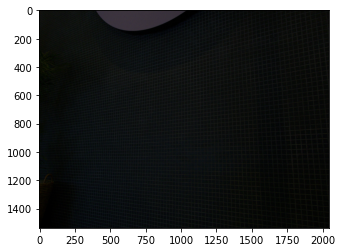

In [ ]:
dbimage=cv2.imread(bef_train_imagenet_data.imgs[11852][0])
dbimage = cv2.cvtColor(dbimage, cv2.COLOR_BGR2RGB)
plt.imshow(dbimage)

TypeError: ignored

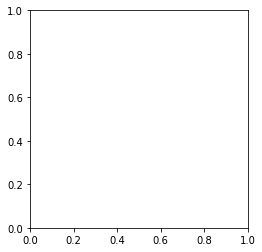

In [ ]:
# dbimage=cv2.imread('/gdrive/My Drive/b1dataset/b1train/2019-04-16_15-35-46DDD/AC01324969_1555399410152000.jpg')
# dbimage = cv2.cvtColor(dbimage, cv2.COLOR_BGR2RGB)
# plt.imshow(dbimage)
#plt.imshow('/gdrive/My Drive/b1dataset/b1train/2019-04-16_15-35-46DDD/AC01324969_1555399410152000.jpg')
plt.imshow('/gdrive/My Drive/b1dataset/b1train/2019-04-16_15-35-46DDD/AC01324969_1555399410152000.jpg', clim=(0.064, 0.068))
